In [1]:
import time
import math
import numpy as np 
import pandas as pd
import statsmodels.api as sm
from termcolor import colored

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from pylab import rcParams

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn

## Load the dataset
All data include the last 10 years values, coming from yahoo finance

In [2]:
google = pd.read_csv('Data/GOOG.csv', index_col='Date', parse_dates=True)
apple = pd.read_csv('Data/AAPL.csv', index_col='Date', parse_dates=True)
microsoft = pd.read_csv('Data/MSFT.csv', index_col='Date', parse_dates=True)

In [3]:
dataset = {'google': google, 'apple': apple, 'microsoft': microsoft}

## Analysis
Analysis step of the project includes: 
1. Check for na
2. Correlation of closing and opening price
3. Attributes visualization
4. Show trend and seasonality

### NAs

In [4]:
[df.isna().sum() for _, df in dataset.items()]

[Open         0
 High         0
 Low          0
 Close        0
 Adj Close    0
 Volume       0
 dtype: int64,
 Open         0
 High         0
 Low          0
 Close        0
 Adj Close    0
 Volume       0
 dtype: int64,
 Open         0
 High         0
 Low          0
 Close        0
 Adj Close    0
 Volume       0
 dtype: int64]

### Correlation

There is a very high correlation between "Open" and "Close"

In [5]:
for name, df in dataset.items():
    print(f'Correlation for {name.upper()}: \n{df.corr().to_markdown()}')
    print(f"{'='}"*90)

Correlation for GOOGLE: 
|           |      Open |      High |       Low |     Close |   Adj Close |    Volume |
|:----------|----------:|----------:|----------:|----------:|------------:|----------:|
| Open      |  1        |  0.999818 |  0.999805 |  0.999576 |    0.999576 | -0.386879 |
| High      |  0.999818 |  1        |  0.999765 |  0.999801 |    0.999801 | -0.384601 |
| Low       |  0.999805 |  0.999765 |  1        |  0.999817 |    0.999817 | -0.390556 |
| Close     |  0.999576 |  0.999801 |  0.999817 |  1        |    1        | -0.388067 |
| Adj Close |  0.999576 |  0.999801 |  0.999817 |  1        |    1        | -0.388067 |
| Volume    | -0.386879 | -0.384601 | -0.390556 | -0.388067 |   -0.388067 |  1        |
Correlation for APPLE: 
|           |      Open |      High |       Low |     Close |   Adj Close |    Volume |
|:----------|----------:|----------:|----------:|----------:|------------:|----------:|
| Open      |  1        |  0.999878 |  0.999854 |  0.999694 |    0.9996

### Attributes visualization

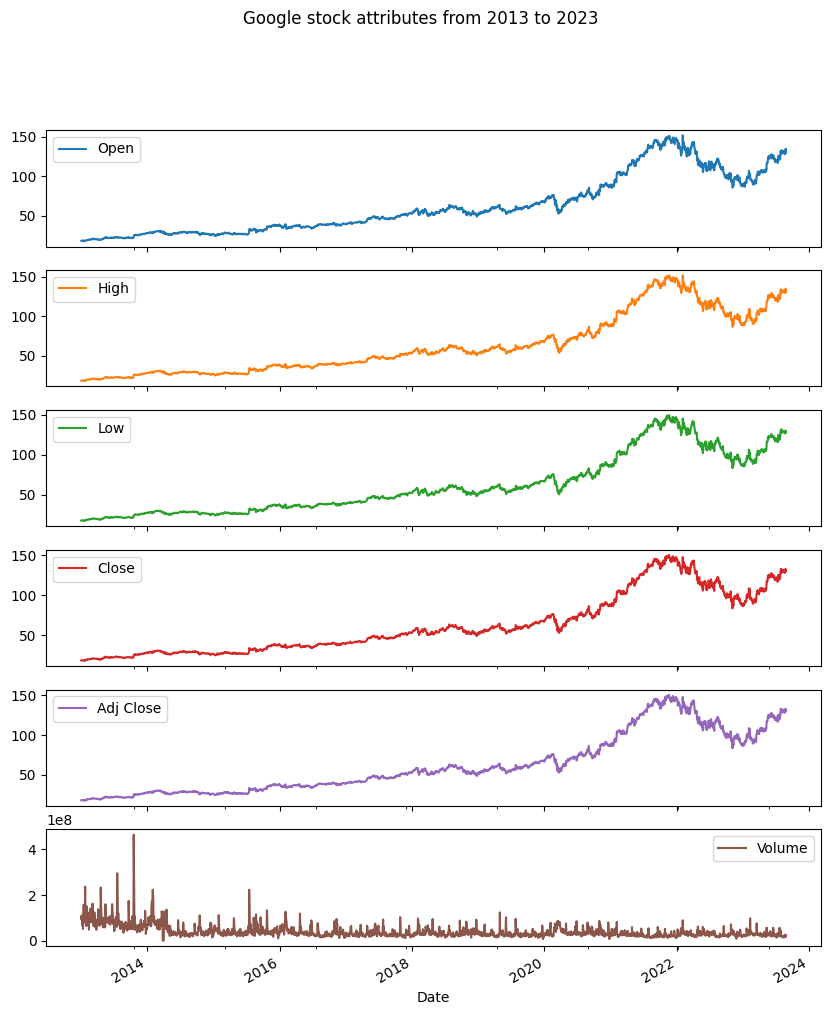

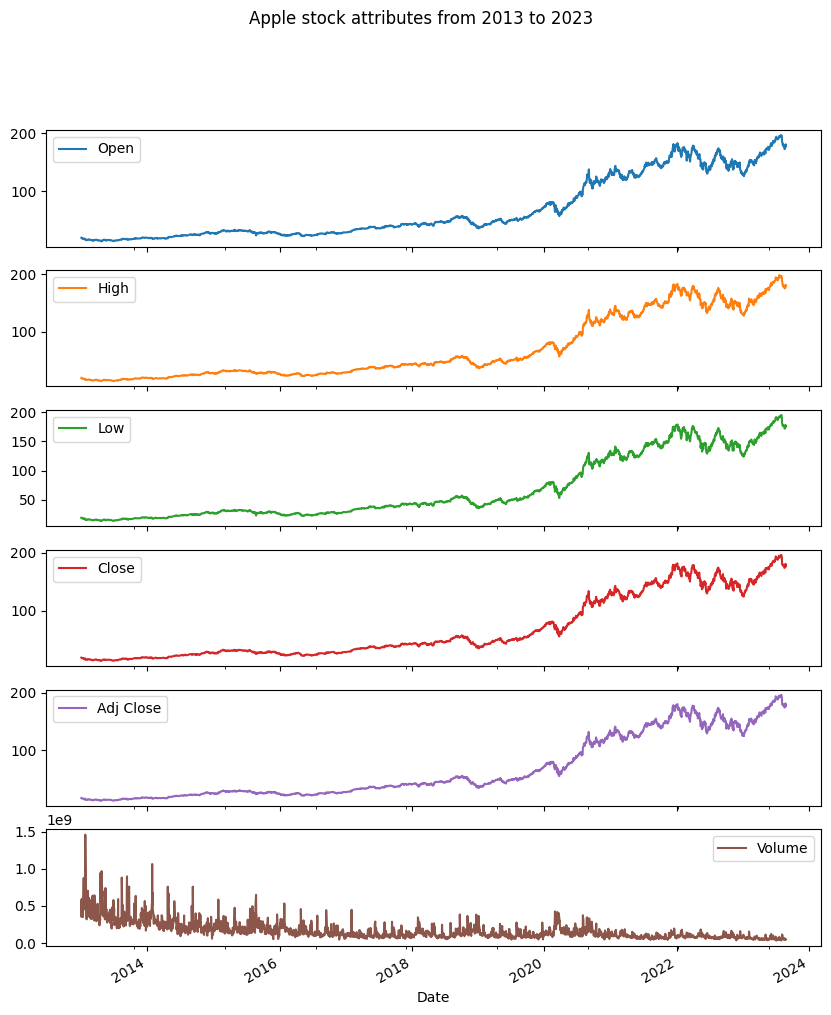

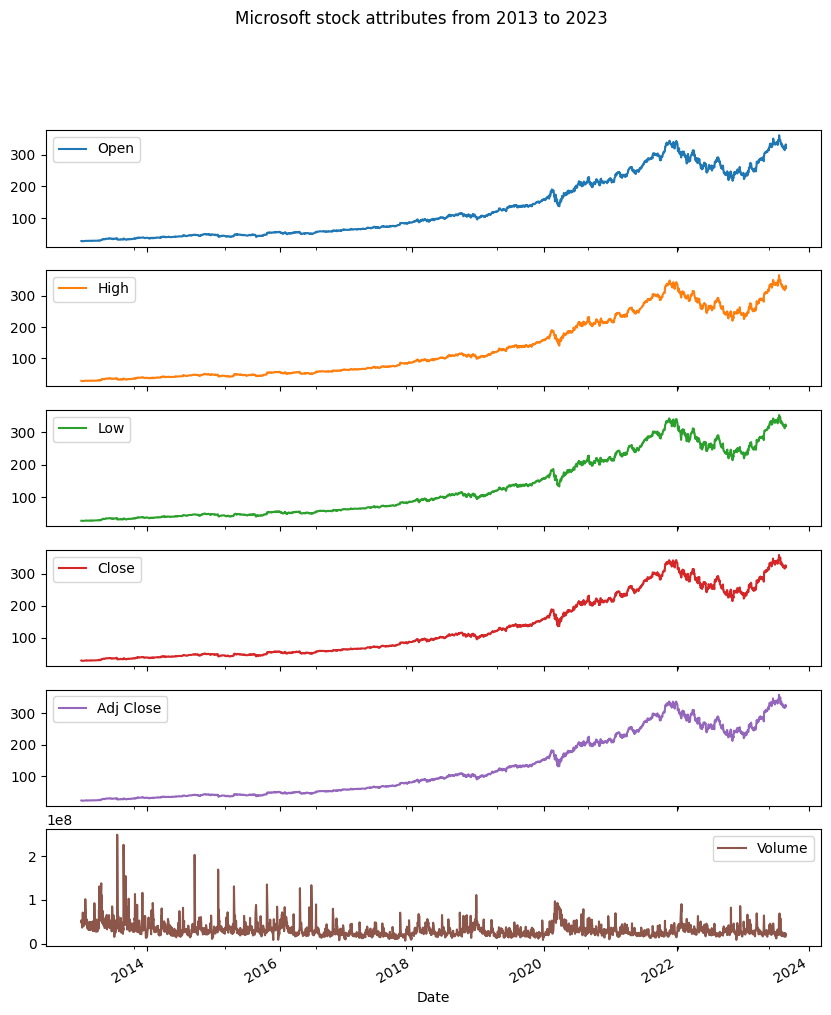

In [6]:
for name, df in dataset.items():
    df.plot(subplots=True, figsize=(10,12), title=f'{name.capitalize()} stock attributes from 2013 to 2023')
    plt.show()

#### High Plot

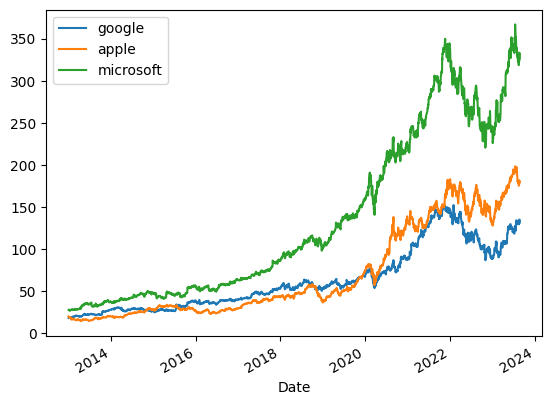

In [7]:
for _, df in dataset.items():
    df.High.plot()
plt.legend(dataset.keys())
plt.show()

#### Close Plot

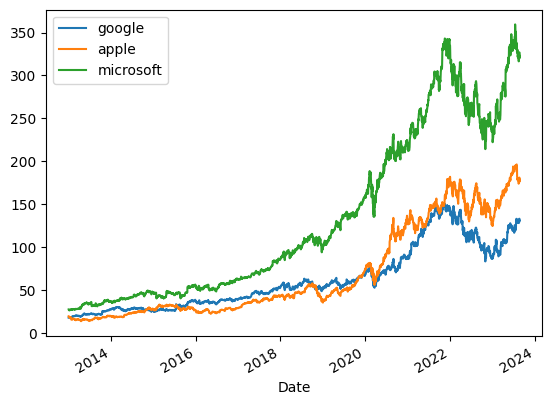

In [8]:
for _, df in dataset.items():
    df.Close.plot()
plt.legend(dataset.keys())
plt.show()

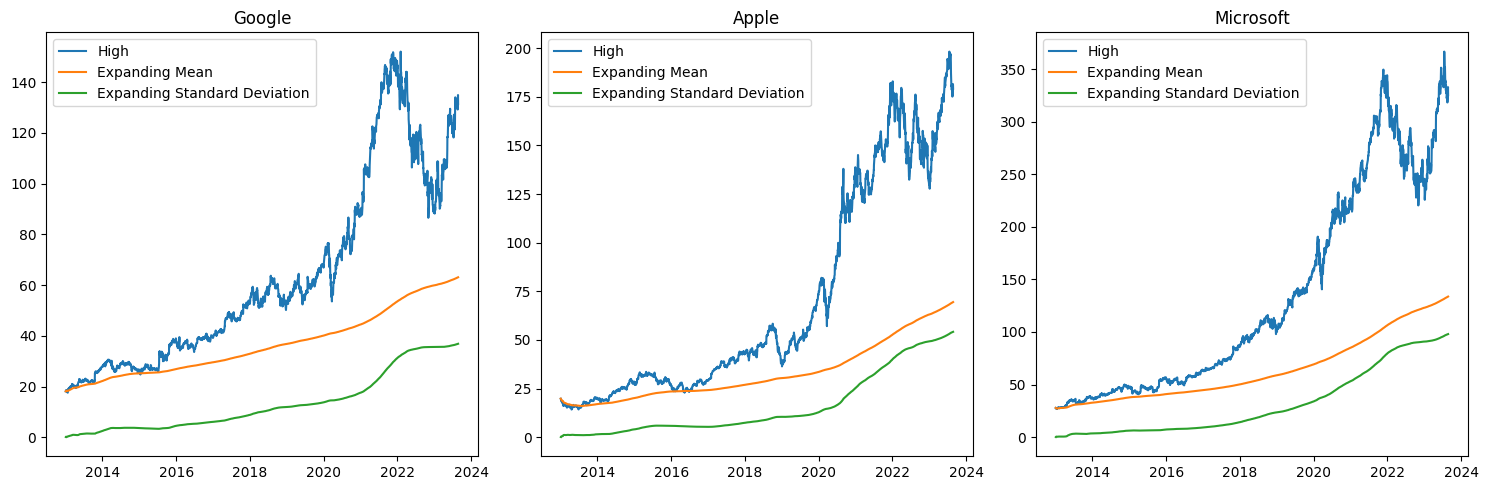

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Una riga e tre colonne

for i, data in enumerate(dataset):
    expanding_mean = dataset[data].High.expanding().mean()
    expanding_std = dataset[data].High.expanding().std()

    axs[i].plot(dataset[data].High, label='High')
    axs[i].plot(expanding_mean, label='Expanding Mean')
    axs[i].plot(expanding_std, label='Expanding Standard Deviation')
    
    axs[i].set_title(f'{data.capitalize()}')
    axs[i].legend()

plt.tight_layout()
plt.show()

"High" value was never under the mean for a long time after 2016, so we can say that they have gone very well until now. Their growth is exponential.
The little decrease step in 2016 may be caused by different social factors: 
- Brexit
- U.S. Elections (November)
- Central Bank Policies

### Trend and Seasonality

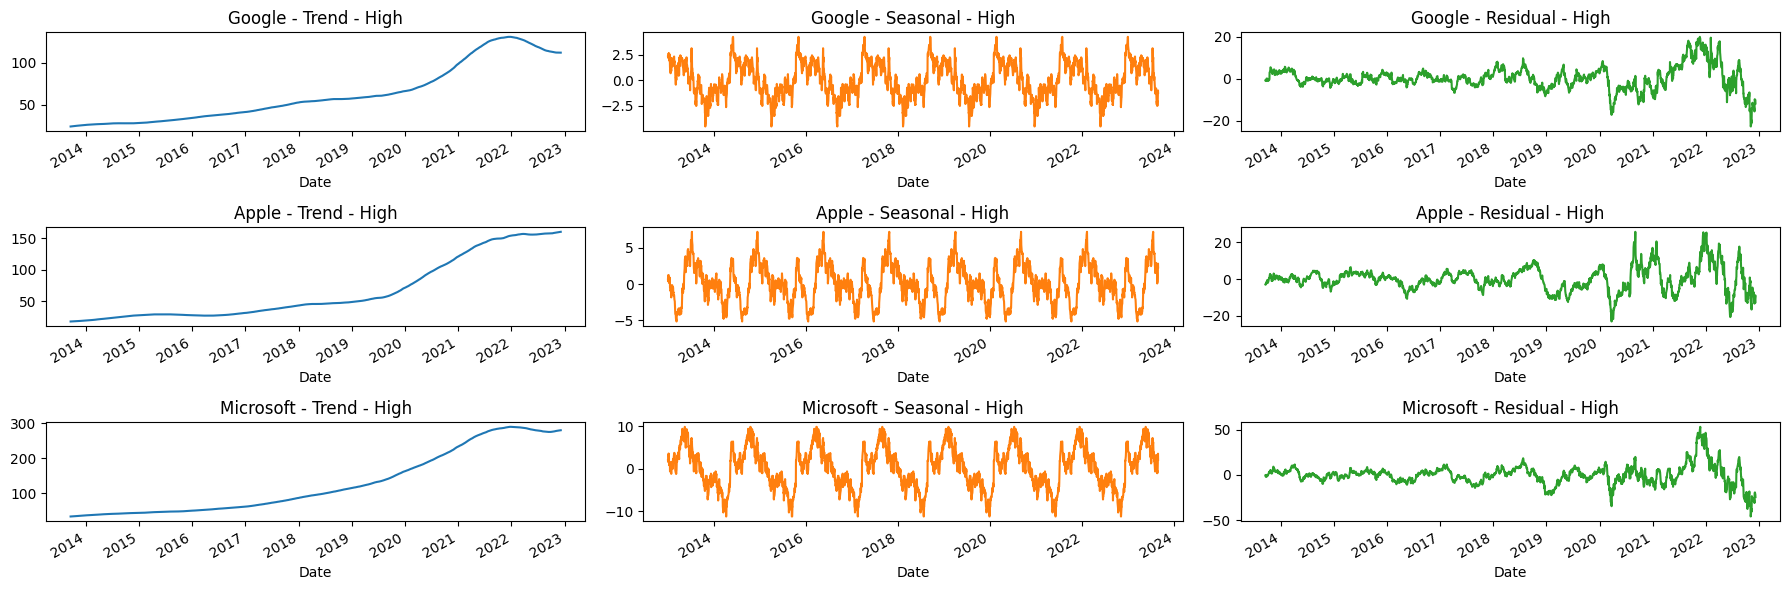

In [16]:
plt.rcParams['figure.figsize'] = 18, 6
fig, axes = plt.subplots(nrows=3, ncols=3)

for i, data in enumerate(dataset):
    ax_trend = axes[i, 0]
    ax_seasonal = axes[i, 1]
    ax_residual = axes[i, 2]
    
    decomposition = sm.tsa.seasonal_decompose(dataset[data]["High"], period=360) # annual period
    decomposition.trend.plot(ax=ax_trend, title=f"{data.capitalize()} - Trend - High", color='tab:blue')   
    decomposition.seasonal.plot(ax=ax_seasonal, title=f"{data.capitalize()} - Seasonal - High", color='tab:orange')
    decomposition.resid.plot(ax=ax_residual, title=f"{data.capitalize()} - Residual - High", color='tab:green')
  
plt.tight_layout()
plt.show()

For all the 3 companies there is an exponential high trend after 2016 and a very high seasonality.

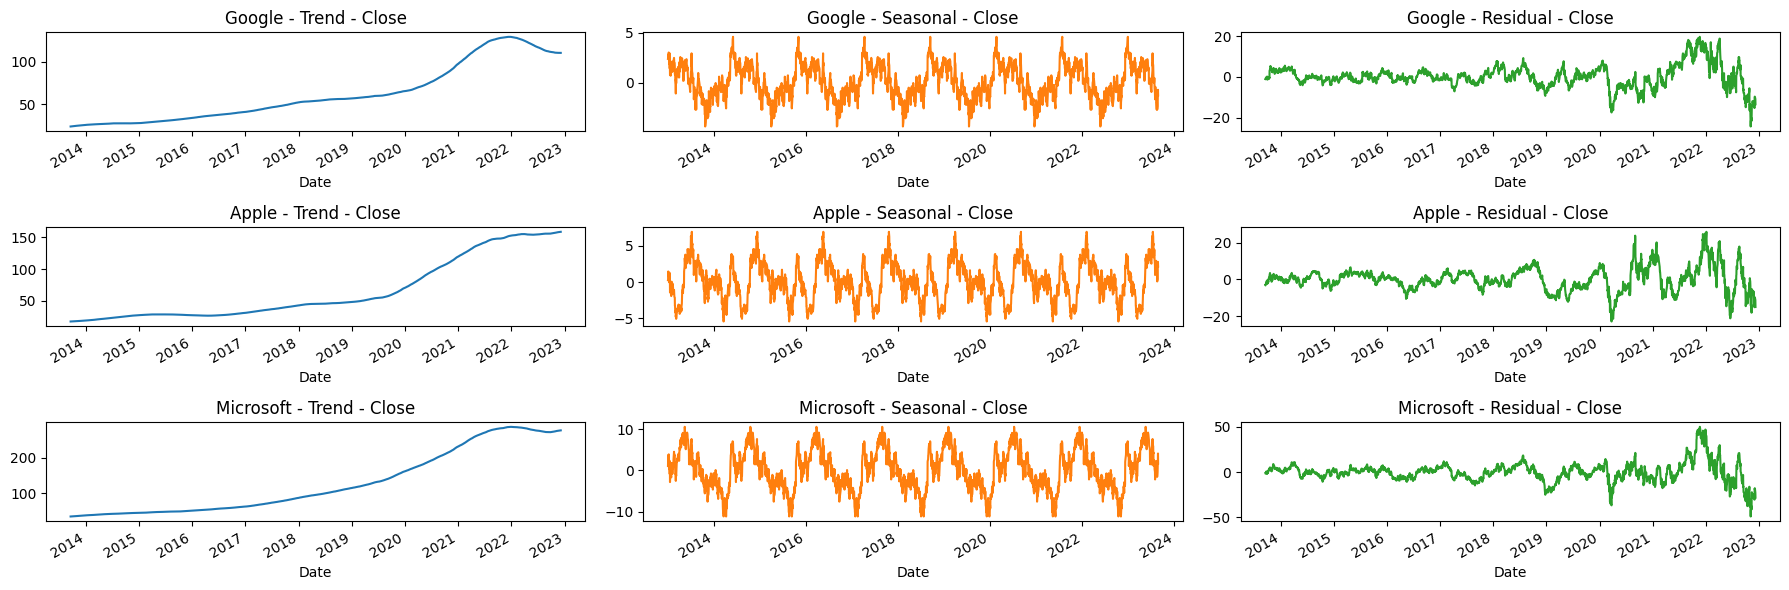

In [17]:
plt.rcParams['figure.figsize'] = 18, 6
fig, axes = plt.subplots(nrows=3, ncols=3)

for i, data in enumerate(dataset):
    ax_trend = axes[i, 0]
    ax_seasonal = axes[i, 1]
    ax_residual = axes[i, 2]
    
    decomposition = sm.tsa.seasonal_decompose(dataset[data]["Close"], period=360) # annual period
    decomposition.trend.plot(ax=ax_trend, title=f"{data.capitalize()} - Trend - Close", color='tab:blue')
    decomposition.seasonal.plot(ax=ax_seasonal, title=f"{data.capitalize()} - Seasonal - Close", color='tab:orange')
    decomposition.resid.plot(ax=ax_residual, title=f"{data.capitalize()} - Residual - Close", color='tab:green')
  
plt.tight_layout()
plt.show()

Since the correlation between Open and Close values is very high the trend and seasonality is very similar

## Time Series Forecasting
Time series forecasting uses information regarding historical data and use them to discover patterns to use to predict future activity. Most often, this relates to trend analysis, cyclical fluctuation analysis, and issues of seasonality. As with all forecasting methods, success is not guaranteed.

We will use a **GRU Model**

Gated recurrent unit is essentially a simplified LSTM. It has the exact same role in the network. The main difference is in the number of gates and weights — GRU is somewhat simpler. It has 2 gates. Since it does not have an output gate, there is no control over the memory content. The update gate controls the information flow from the previous activation, and the addition of new information as well, while the reset gate is inserted into the candidate activation.

### Defining the GRU model

In [196]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [198]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [199]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

### Some functions

In [197]:
def split_data(stock, lookback, test_size=0.2):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(test_size * data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [261]:
def plot_results(original, predict, hist, name):
    sns.set_style("darkgrid")

    fig = plt.figure(figsize=(11, 6))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    plt.subplot(1, 2, 1)
    ax = sns.lineplot(x=original.index, y=original[0], label="Data", color='royalblue')
    ax = sns.lineplot(x=predict.index, y=predict[0], label="Training Prediction (GRU)", color='tomato')
    ax.set_title(f'{name} stock price', size=14, fontweight='bold')
    ax.set_xlabel("Days", size=14)
    ax.set_ylabel("Cost (USD)", size=14)
    ax.set_xticklabels('', size=10)

    plt.subplot(1, 2, 2)
    ax = sns.lineplot(data=hist, color='royalblue')
    ax.set_xlabel("Epoch", size=14)
    ax.set_ylabel("Loss", size=14)
    ax.set_title("Training Loss", size=14, fontweight='bold')

    plt.show()

In [266]:
def invert_predictions(y_train_pred, y_train_gru, y_test_pred, y_test_gru):
    y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
    y_train = scaler.inverse_transform(y_train_gru.detach().numpy())
    y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
    y_test = scaler.inverse_transform(y_test_gru.detach().numpy())

    return y_train_pred, y_train, y_test_pred, y_test

In [264]:
def print_scores(y_train_pred, y_train_gru, y_test_pred, y_test_gru, scaler):
    # Calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(y_train[:, 0], y_train_pred[:, 0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(y_test[:, 0], y_test_pred[:, 0]))
    print('Test Score: %.2f RMSE' % (testScore))

    return None

In [250]:
def format_dataframe(y_train_pred, y_test_pred, price, scaler, lookback):
    # Shift train predictions for plotting
    trainPredictPlot = np.empty_like(price)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[lookback : len(y_train_pred) + lookback, :] = y_train_pred

    # Shift test predictions for plotting
    testPredictPlot = np.empty_like(price)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(y_train_pred) + lookback - 1 : len(price) - 1, :] = y_test_pred

    original = scaler.inverse_transform(price['Close'].values.reshape(-1, 1))

    predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
    predictions = np.append(predictions, original, axis=1)
    result = pd.DataFrame(predictions)

    return result

In [290]:
def show_interactive_plot(data, name):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=data.index, y=data[0], mode='lines', name='Train prediction'))
    fig.add_trace(go.Scatter(x=data.index, y=data[1], mode='lines', name='Test prediction'))
    fig.add_trace(go.Scatter(x=data.index, y=data[2], mode='lines', name='Actual Value'))
    fig.update_layout(
        xaxis=dict(
            showline=True,
            showgrid=True,
            showticklabels=False,
            linecolor='black',
            linewidth=2
        ),
        yaxis=dict(
            title_text='Close (USD)',
            titlefont=dict(
                family='Rockwell',
                size=12,
                color='black',
            ),
            showline=True,
            showgrid=True,
            showticklabels=True,
            linecolor='white',
            linewidth=2,
            ticks='outside',
            tickfont=dict(
                family='Rockwell',
                size=12,
                color='black',
            ),
        ),
        showlegend=True,
        template='ggplot2'
    )
    annotations = []
    annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                            xanchor='left', yanchor='bottom',
                            text=f'{name} Stock Prediction',
                            font=dict(family='Rockwell',
                                      size=26,
                                      color='black'),
                            showarrow=False))
    fig.update_layout(annotations=annotations)
    fig.show()

### Main

In [200]:
scaler = MinMaxScaler(feature_range=(-1, 1))

In [248]:
lookback = 20 # sequence length

********* GOOGLE *********
x_train: (2129, 19, 1) 
y_train: (2129, 1)
x_test: (532, 19, 1) 
y_test: (532, 1)
Epoch  0 MSE:  0.00018532534886617213
Epoch  1 MSE:  0.00018451666983310133
Epoch  2 MSE:  0.00018393402569927275
Epoch  3 MSE:  0.00018398179963696748
Epoch  4 MSE:  0.0001839055767050013
Epoch  5 MSE:  0.00018325934070162475
Epoch  6 MSE:  0.00018259159696754068
Epoch  7 MSE:  0.00018242232908960432
Epoch  8 MSE:  0.00018254684982821345
Epoch  9 MSE:  0.00018247040861751884
Epoch  10 MSE:  0.0001821778278099373
Epoch  11 MSE:  0.00018208776600658894
Epoch  12 MSE:  0.00018227870168630034
Epoch  13 MSE:  0.00018240661302115768
Epoch  14 MSE:  0.00018229878332931548
Epoch  15 MSE:  0.00018213815928902477
Epoch  16 MSE:  0.00018212178838439286
Epoch  17 MSE:  0.00018215521413367242
Epoch  18 MSE:  0.00018203743093181401
Epoch  19 MSE:  0.00018181311315856874
Epoch  20 MSE:  0.00018166482914239168
Epoch  21 MSE:  0.0001816152798710391
Epoch  22 MSE:  0.0001815474679460749
Epoch  2

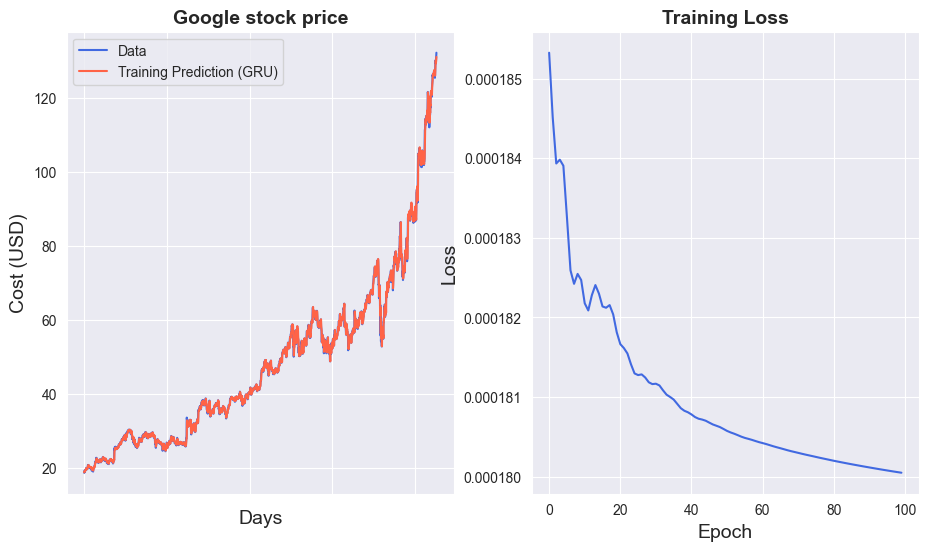

Train Score: 0.89 RMSE
Test Score: 2.55 RMSE


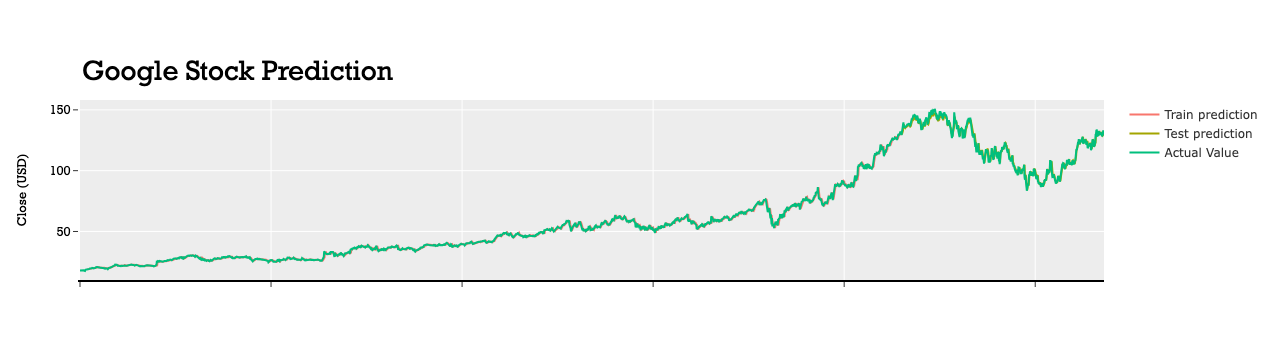

********* APPLE *********
x_train: (2129, 19, 1) 
y_train: (2129, 1)
x_test: (532, 19, 1) 
y_test: (532, 1)
Epoch  0 MSE:  0.00016202741244342178
Epoch  1 MSE:  0.00016223551938310266
Epoch  2 MSE:  0.0001622523122932762
Epoch  3 MSE:  0.00016196143405977637
Epoch  4 MSE:  0.00016164030239451677
Epoch  5 MSE:  0.00016153912292793393
Epoch  6 MSE:  0.00016158731887117028
Epoch  7 MSE:  0.00016155437333509326
Epoch  8 MSE:  0.0001613689528312534
Epoch  9 MSE:  0.0001611783227417618
Epoch  10 MSE:  0.00016112874436657876
Epoch  11 MSE:  0.0001611913467058912
Epoch  12 MSE:  0.00016122538363561034
Epoch  13 MSE:  0.0001611597544979304
Epoch  14 MSE:  0.000161061980179511
Epoch  15 MSE:  0.00016103102825582027
Epoch  16 MSE:  0.00016107354895211756
Epoch  17 MSE:  0.00016110925935208797
Epoch  18 MSE:  0.00016107692499645054
Epoch  19 MSE:  0.00016100182256195694
Epoch  20 MSE:  0.00016095073078759015
Epoch  21 MSE:  0.00016094888269435614
Epoch  22 MSE:  0.00016095911269076169
Epoch  23 MS

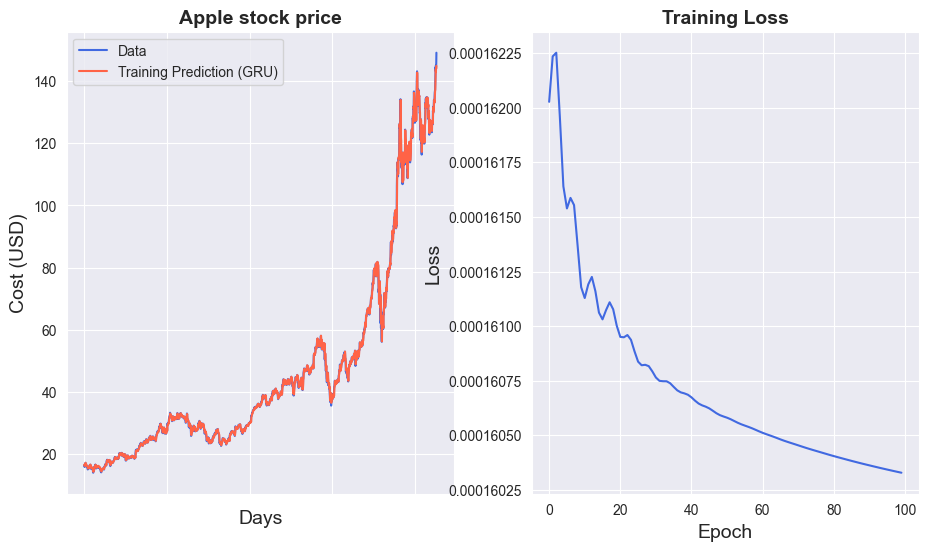

Train Score: 1.16 RMSE
Test Score: 3.20 RMSE


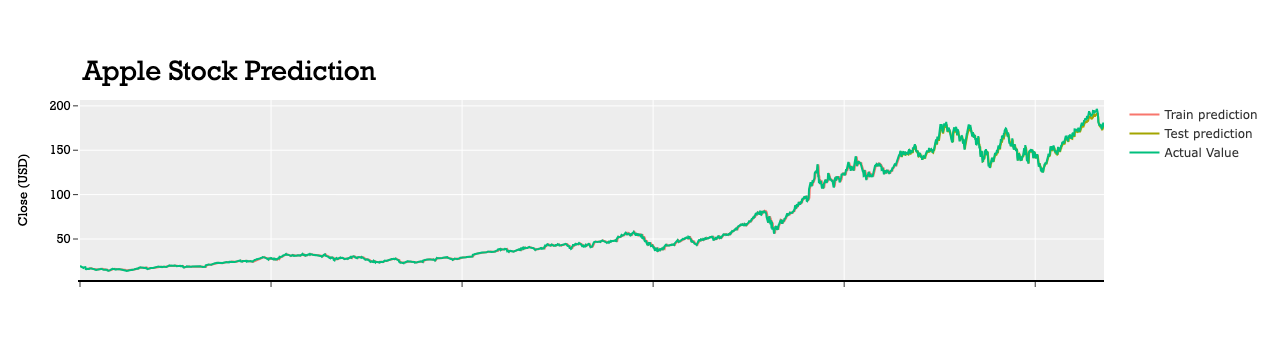

********* MICROSOFT *********
x_train: (2129, 19, 1) 
y_train: (2129, 1)
x_test: (532, 19, 1) 
y_test: (532, 1)
Epoch  0 MSE:  0.00015117246948648244
Epoch  1 MSE:  0.00015114749839995056
Epoch  2 MSE:  0.00015108499792404473
Epoch  3 MSE:  0.00015098780568223447
Epoch  4 MSE:  0.00015087125939317048
Epoch  5 MSE:  0.00015075253031682223
Epoch  6 MSE:  0.00015063538739923388
Epoch  7 MSE:  0.00015051221998874098
Epoch  8 MSE:  0.00015038195124361664
Epoch  9 MSE:  0.0001502553204772994
Epoch  10 MSE:  0.0001501395454397425
Epoch  11 MSE:  0.00015002813597675413
Epoch  12 MSE:  0.00014991282660048455
Epoch  13 MSE:  0.00014979600382503122
Epoch  14 MSE:  0.00014968532195780426
Epoch  15 MSE:  0.00014958143583498895
Epoch  16 MSE:  0.00014947939780540764
Epoch  17 MSE:  0.00014937760715838522
Epoch  18 MSE:  0.0001492793671786785
Epoch  19 MSE:  0.0001491869770688936
Epoch  20 MSE:  0.0001490994618507102
Epoch  21 MSE:  0.00014901476970408112
Epoch  22 MSE:  0.00014893223124090582
Epoch 

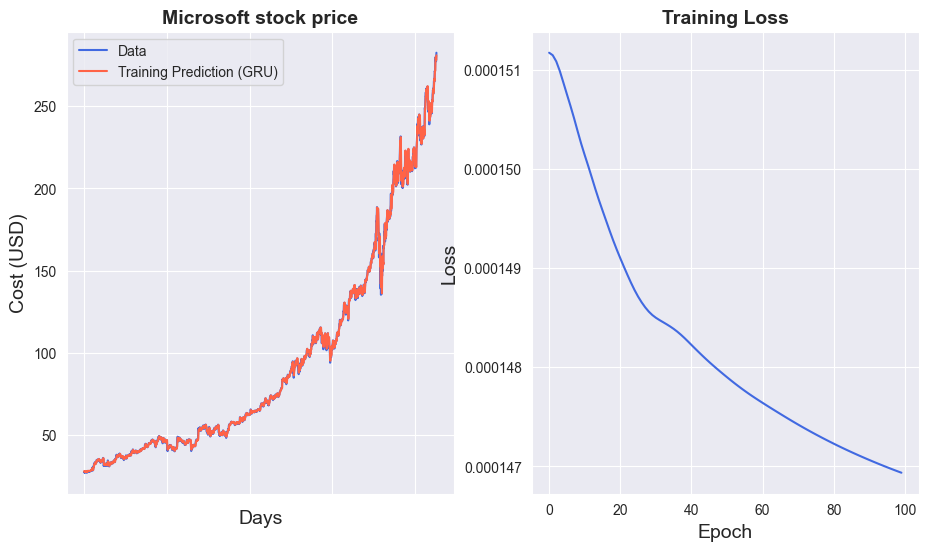

Train Score: 2.02 RMSE
Test Score: 5.56 RMSE


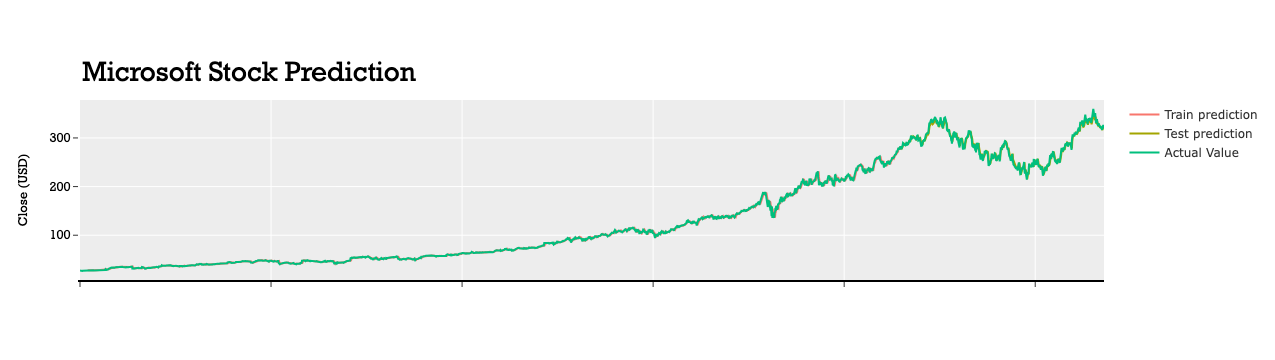

In [292]:
for data in dataset:
    print(colored(f'********* {data.upper()} *********','red'))
    
    # get the close value price we want to predict
    price = dataset[data][['Close']].reset_index(drop=True).copy()
    price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1, 1))

    # split dataset
    x_train, y_train, x_test, y_test = split_data(price, lookback)
    print(f'x_train: {x_train.shape} \ny_train: {y_train.shape}')
    print(f'x_test: {x_test.shape} \ny_test: {y_test.shape}')

    # convert to pytorch tensor
    x_train = torch.from_numpy(x_train).type(torch.Tensor)
    x_test = torch.from_numpy(x_test).type(torch.Tensor)
    y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
    y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

    # training process
    loss_history = np.zeros(num_epochs)
    start_time = time.time()
    
    for t in range(num_epochs):   
        y_train_pred = model(x_train)
        
        loss = criterion(y_train_pred, y_train_gru)
        print("Epoch ", t, "MSE: ", loss.item())
        loss_history[t] = loss.item()
    
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    
    print(f"Training time: {round(time.time()-start_time)}s")

    # plot the training results
    predicted_data = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
    original_data = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().numpy()))
    plot_results(original_data, predicted_data, loss_history, data.capitalize())

    # make predictions
    y_test_pred = model(x_test)
    
    # invert predictions
    y_train_pred, y_train, y_test_pred, y_test = invert_predictions(y_train_pred, y_train_gru, y_test_pred, y_test_gru)
    
    # print score on train and test set
    print_scores(y_train_pred, y_train_gru, y_test_pred, y_test_gru, scaler)

    # generate a pandas dataframe to plot
    result_dataframe = format_dataframe(y_train_pred, y_test_pred, price, scaler, lookback)
    show_interactive_plot(result_dataframe, data.capitalize())

It can be seen from the various plots and results that the prediction is correct, for the 3 different companies